# Benchmark M3.2: Water flow in roots - Static root system

by Daniel Leitner, Andrea Schnepf 

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os
from rsml import * 
from van_genuchten import *

## Comparison of numerical solutions to reference solution

We compare different numerical codes by comparing them to the hybrid analytical solution given by Meunier et al. 2017. In addition, we provide links to Jupyter Notebooks that describe the numerical implementation of a benchmark problem in a specific code should they be available in the subfolder 'M3.2 Model descriptions'

### Result data format of M3.2(a) and M3.2(b)

The results are stored in a text file consisting of two rows, containing comma separated depth values [cm] in the first, and pressure head [cm] in the second row. Locate the file either in the folder 'M3.2a Numerical results' or 'M3.2b Numerical results'

### Comparison to the hybrid analytical solution 

We compare the numerical results of the simulators to the hybrid analytical solution given by Meunier et al. 2017, that is stored in 'M3.2a Numerical results/Reference.csv' and 'M3.2b Numerical results/Reference.csv'

(2, 2884)
1. DuMux:from  -498.4342348369011 to -240.76349069826708  cm pressure head

2. OpenSimRoot:from  -496.8 to -241.8  cm pressure head

4. RSWMS:from  -495.492 to -240.77  cm pressure head

5. SRI:from  -500.0 to -240.647  cm pressure head



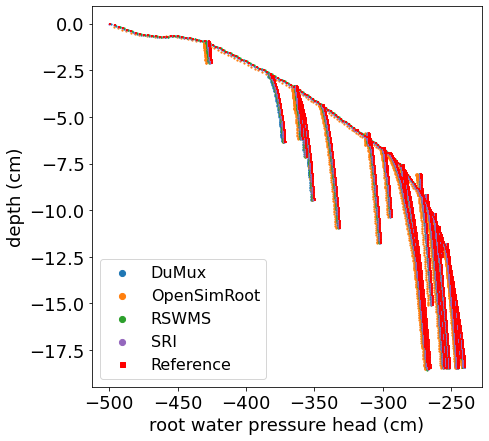

(2, 2884)
1. DuMux:from  -498.1539086391437 to -199.24160614169216  cm pressure head

2. OpenSimRoot:from  -496.2 to -199.2  cm pressure head

4. RSWMS:from  -494.734 to -199.236  cm pressure head

5. SRI:from  -500.0 to -199.151  cm pressure head



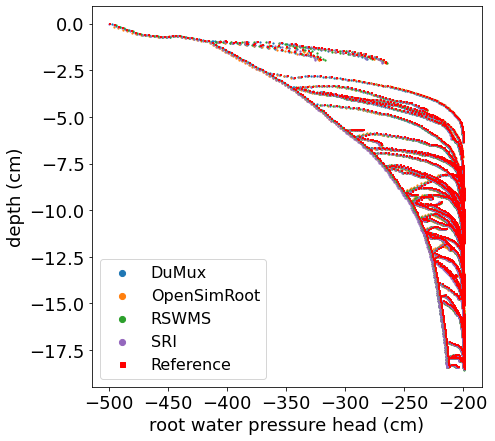

In [16]:
def plot_results(path, xmin, xmax, ymin, ymax):

    fig, ax = plt.subplots(1, 1, figsize=(7,7)) 
    ax = [ax]
    l = []
    data = np.loadtxt(path+'Reference',delimiter=',') # analytical solution
    print(data.shape)
    z_a = data[0,:]; #z_a=z_a[1::5];
    psi_a = data[1,:]; #psi_a = psi_a[1::5];
    #ax[0].scatter(psi_a, z_a, marker ='*', color = 'red', s=1.5)
    # ax[0].plot(psi_a, z_a, 'r*')
    
    cc = 0
    nrsmea, namea = [] ,[]
    for dirname, dirnames, filenames in os.walk(path+'.'):
        filenames.sort(key=str.lower)
        for i,f in enumerate(filenames):
            try:
                if f!="Reference":
                    l.append(f)
                    data = np.loadtxt(path+f,delimiter=',')  
                    print(str(i+1)+". "+f+":from ", min(data[1,:]), "to", max(data[1,data[1,:]<-1]), " cm pressure head\n") 
                    ax[0].scatter(data[1,data[1,:]<-1], data[0,data[1,:]<-1], color = col[cc,:], s = 1.5)
                    z_n = data[0,:]
                    psi_n = data[1,:]
                    interp = interp1d(z_n, psi_n,  kind='linear', fill_value='extrapolate', bounds_error = False) 
                    psi_n = interp(z_a)                 
                    nrsmea.append(nRMSE(psi_a,psi_n))
                    namea.append(f)
                    cc += 1
            except Exception as ex:
                print("Something went wrong with file "+f)    
                raise            
    
    ax[0].scatter(psi_a, z_a, marker =',', color = 'red', s=1) 
    l.append("Reference")
    # ax[0].plot(psi_a, z_a, 'r*')
    
    ax[0].set_xlabel("root water pressure head (cm)")  
    # ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylabel("depth (cm)")  
    # ax[0].set_ylim(ymin, ymax)
    ax[0].legend(l, loc = 3, markerscale=5)    
    plt.savefig(path.lower()[:-1]+".png", dpi=300, bbox_inches = "tight")
    plt.show() 
    return nrsmea, namea

nrsmea, names = plot_results('M3.2a Numerical results/', -350, -230, -19, - 2.5)
nrsmeb, names = plot_results('M3.2b Numerical results/', -300, -190, -19, 0)

### Preperation of data

In the result data format description, we unfortunately did not fix, which way the values correspond to the underlying grid. Different simulators submitted values per node, segment, or sequentially per polyline. We will first convert the result data, so that we have one value per node, and store the results in a Python dictionary, one entry per simulator.

In [ ]:
def convert_data(all_data, path):
    for dirname, dirnames, filenames in os.walk(path+'.'):
        filenames.sort()
        for i,f in enumerate(filenames):
            try:
                data = np.loadtxt(path+f,delimiter=',')  
                if f == 'RSWMS': # hack to remvoe nan values
                    data = np.array([data[0, ~np.isnan(data[0,:])], data[1, ~np.isnan(data[1,:])]])   
                    data = np.insert(data, 0, [0, -500], axis=1)
                if f == 'Dumux':
                    data = np.insert(data, 0, [0, -500], axis=1)
                if f == 'OpenSimRoot': # data are per polyline node (?), sorted in an unexpected way
                    # delete first node of each polyline
                    # data[0,:] = np.sort(data[0,:])[::-1]
                    continue # skip OpenSimRoot for now
                all_data[f] = data
            except Exception as ex:
                print("Something went wrong with file "+f)    
                raise     

data_a = {} 
data_b = {}                 
convert_data(data_a, 'M3.2a Numerical results/')
convert_data(data_b, 'M3.2b Numerical results/')

In [ ]:
# compare two results (reference vs simulator)
simulator1 = "SRI"
simulator2 = "RSWMS"

data_ref = data_a[simulator2] # pick data_a or data_b for sceanrios a, b
data = data_a[simulator1] 

cmap = plt.get_cmap("jet", 256) # blue is upper, red is lower

cols = data[0,:]/-18.6*255
cols = cols.round()
cols = cols.astype(int)
plt.scatter(data_ref[1,:], data[1,:], color = cmap(cols), marker = ".") 
plt.xlabel("root water pressure head ("+simulator2+")")
plt.ylabel("root water pressure head ("+simulator1+")")
plt.show()

In [ ]:
def plot_layers(path):    
    fig, ax = plt.subplots(1, 1, figsize=(7,7)) 
    ax = [ax]    
    l = ["Reference"]    
    data = np.loadtxt(path+l[0],delimiter=',') # analytical solution
    ind = np.argsort(data[0,:])                
    psi_a = data[1, ind]
    z_a = data[0, ind]
    layer_mean_a = [np.mean(psi_a[(z_a>-i-1) & (z_a<=-i) & (psi_a<-1)]) for i in range(0,18)]
    
    ax[0].plot(layer_mean_a, -np.linspace(0.5,17.5,18), color = 'red', alpha = 0.5, linewidth = 2)
    cc = 1
    nrsmea, namea = [] ,[]
    for dirname, dirnames, filenames in os.walk(path+'.'):
        filenames.sort()
        for i,f in enumerate(filenames):
            try:
                if f!="Reference":
                    l.append(f)
                    data = np.loadtxt(path+f,delimiter=',')        
                    print(str(i+1)+". "+f+":from ", min(data[1,:]), "to", max(data[1,data[1,:]<-1]), " cm pressure head\n") 
                    ind = np.argsort(data[0,:])                
                    psi_ = data[1, ind]
                    z_ = data[0, ind]
                    layer_mean_a = [np.mean(psi_[(z_>-i-1) & (z_<=-i) & (psi_<-1)]) for i in range(0,18)]                    
                    ax[0].plot(layer_mean_a, -np.linspace(0.5,17.5,18), color = col[cc,:], alpha = 0.5, linewidth = 2)                
                    cc += 1
            except Exception as ex:
                print("Something went wrong with file "+f)    
                raise            
    ax[0].set_xlabel("root water pressure head (cm)")  
    ax[0].set_ylabel("depth (cm)")  
    ax[0].legend(l, loc = "lower left")
    plt.savefig('m32_layers.png', dpi=300, bbox_inches = "tight")
    plt.show() 
    
plot_layers('M3.2a Numerical results/')
plot_layers('M3.2b Numerical results/')

Table compares wrong value, must map one to one by guessing...

In [ ]:
import pandas as pd 

data_ = np.array([names, nrsmea, nrsmeb]) # TODO nrsmeb is gone (?)
data_ = np.array(data_.transpose())

df = pd.DataFrame(data_, columns = ['Name','nRSME (a)','nRSME (b)'] ) # Create the pandas DataFrame 
df['nRSME (a)'] = df['nRSME (a)'].astype(float)
df['nRSME (a)'] = df['nRSME (a)'].map('{:,.4f}'.format)
df['nRSME (b)'] = df['nRSME (b)'].astype(float)
df['nRSME (b)'] = df['nRSME (b)'].map('{:,.4f}'.format)

df.style.set_table_styles(
[{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},
]
).hide_index()

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
fig.savefig("table_m32.png")

## References

Meunier F., Draye X., Vanderborght J., Javaux M., and Couvreur V. (2017) A hybrid analytical-numerical method for solving water flow equations in root hydraulic architectures *Applied Mathematical modelling*.